# Happy Hotel Data Challenge

#### You've just joined the data team at a large hoteling chain. Your specific team is embedded in the CX (customer experience) division. Each day you receive hundreds of reviews of your 10 hotels from your customers. Each review consists of a free-form text review and a report of "happy" or "not happy". A product manager on your team wants to understand each hotel's performance at a more granular level; they want to build a product to identify topics within reviews. All of your reviews are unlabeled, and it's infeasible to label them by hand.

1. Design and execute a method to identify topics within the reviews. 
2. For each topic, find a robust means of assigning a score to each hotel in that topic. 
3. For each of the ten hotels, what specific-to-that-hotel recommendations would you make to their general managers?
4. Engineering Challenge: How would you design this system to update over time? How would you persist topics from one timestep/update to another? How would you design your scores so they can meaningfully understand when they’re doing better?


##  Import Data

In [52]:
#Load libraries
import nltk
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# load data
happy = pd.read_csv('HappyHotel/hotel_happy_reviews.csv')
unhappy = pd.read_csv('HappyHotel/hotel_not_happy_reviews.csv')
reviews_df = happy.append(unhappy, ignore_index=True)
reviews_df.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10329,Stayed here with husband and sons on the way t...,happy,8
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3


In [53]:
# Checking for duplicated rows... 
reviews_df.info()
print("-----------")
print(reviews_df.nunique())
print("-----------")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 4 columns):
User_ID        38932 non-null object
Description    38932 non-null object
Is_Response    38932 non-null object
hotel_ID       38932 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.2+ MB
-----------
User_ID        38932
Description    38932
Is_Response        2
hotel_ID          10
dtype: int64
-----------


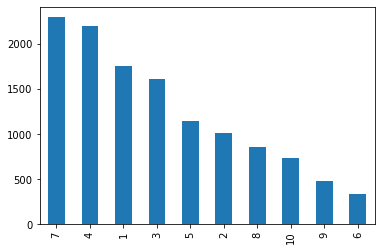

In [49]:
unhappy['hotel_ID'].value_counts().plot(kind='bar')

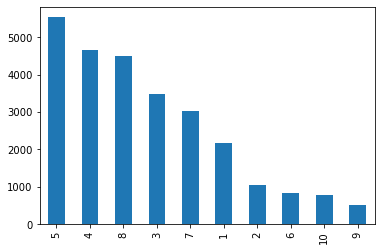

In [50]:
# happy['hotel_ID'].value_counts()
happy['hotel_ID'].value_counts().plot(kind='bar')

### Word clouds from negative and positive reviews using TF 

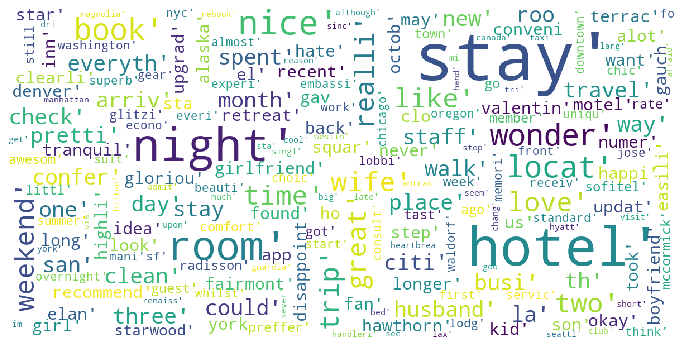

In [126]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

happy_clean = pd.read_csv("HappyHotel/hotel_happy_clean-reviews.csv")
unhappy_clean = pd.read_csv("HappyHotel/hotel_not_happy_clean-reviews.csv")
show_wordcloud(happy_clean['clean_text'])

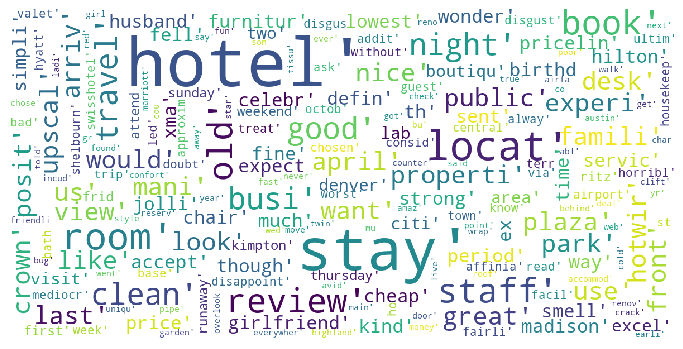

In [127]:
show_wordcloud(unhappy_clean['clean_text'])

## Text processing Hotel Reviews

In [54]:
import re

# download dataset for tokenizer
# nltk.download('punkt')
from nltk.tokenize import word_tokenize

# download stopwords list to filter out in sentences
# nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def process_text(text):
    """
    Processes text by 1) convert words to lowercase 
    and remove non alphabetic characters, 2)tokenize 
    the text and separate every sentence into a list 
    of words, 3)remove stopwords and stem each word 
    to the root

    Parameters:
    ----------
    text : row with text in pandas column

    Returns:
    -------
    clean_text : cleaned text based on processing
    methods
    """
    
    text = re.sub('[^A-Za-z]', ' ', text.lower())
    tokenized_text = word_tokenize(text)
    clean_text = [
        stemmer.stem(word) for word in tokenized_text
        if word not in stopwords.words('english')
    ]

    # return list of clean words
    return clean_text

In [33]:
# happy['clean_text'] = happy.Description.apply(lambda x: process_text(x))
# unhappy['clean_text'] = unhappy.Description.apply(lambda x: process_text(x))

In [55]:
reviews_df['clean_text'] = reviews_df.Description.apply(lambda x: process_text(x))

In [56]:
reviews_df.Description[0]

'Stayed here with husband and sons on the way to an Alaska Cruise. We all loved the hotel, great experience. Ask for a room on the North tower, facing north west for the best views. We had a high floor, with a stunning view of the needle, the city, and even the cruise ships! We ordered room service for dinner so we could enjoy the perfect views. Room service dinners were delicious, too! You are in a perfect spot to walk everywhere, so enjoy the city. Almost forgot- Heavenly beds were heavenly, too!'

In [57]:
reviews_df.head()

,User_ID,Description,Is_Response,hotel_ID,clean_text
0,id10329,Stayed here with husband and sons on the way t...,happy,8,"[stay, husband, son, way, alaska, cruis, love,..."
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3,"[room, one, nice, clearli, updat, recent, clea..."
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3,"[wife, stay, gloriou, citi, back, sf, expens, ..."
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7,"[boyfriend, stay, fairmont, recent, trip, san,..."
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3,"[step, time, squar, nice, room, stay, night, g..."


In [59]:
#output csv clean reviews so we don't have to continue this process 
# reviews_df.to_csv('HappyHotel/hotel_reviews_clean-reviews.csv', index = False)

## 1. Design and execute a method to identify topics within the reviews.

    A. Create a dictictionary 
    B. Create a 'bag of words' Corpus using TFIDF  
    C. Use both dictionary and Corpus as input to fit a LDA topic modeling using Gensim.

In [61]:
from gensim import corpora
from gensim import models

def get_topic_features(col):
    """
    Processes text by 1) convert words to lowercase 
    and remove non alphabetic characters, 2)tokenize 
    the text and separate every sentence into a list 
    of words, 3)remove stopwords and stem each word 
    to the root

    Parameters:
    ----------
    col : Column of cleaned text wihtin a
    pandas dataframe 

    Returns:
    -------
    LDA model, Corpus, and Dictionary : 
    fit LDA model using TFIDF 
    """
    # make topics from pandas column
#     colname = col.name
    col = col.astype(str).apply(lambda x:x.split())
    dictionary = corpora.Dictionary(col)
    corpus = [dictionary.doc2bow(text) for text in col] # Term Document Frequency
    tfidf = models.TfidfModel(corpus) #tfidf model 
    corpus_tfidf = tfidf[corpus]
    lda = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=20, passes=2)
#     topics = lda.print_topics(-1)
    return lda, corpus_tfidf, dictionary

# get topic distribution for doc
# def get_topics(words): return dict(lda[dictionary.doc2bow(words)])
#     topics_df = pd.DataFrame(col.apply(get_topics).tolist()).fillna(0.001)
#     topics_df.columns = ['topic_'+str(cn)+'_'+colname for cn in topics_df.columns]
#     return topics_df

In [62]:
lda_model_reviews, reviews_corpus, reviews_dict = get_topic_features(reviews_df.clean_text)

In [86]:
#Save coprus and dict to disk so that we don't have to repeat the get_topic_features methods
reviews_dict.save('reviews_dict.dict')  # save dict to disk
corpora.MmCorpus.serialize('reviews_corpus.mm', reviews_corpus)  # 

In [84]:
import pprint
pp = pprint.PrettyPrinter(depth=6)
pp.pprint(lda_model_reviews.print_topics())

[(0,
  '0.018*"\'garbag\'," + 0.012*"[\'well\'," + 0.011*"\'truck\'," + '
  '0.009*"\'alright\'," + 0.009*"\'option\']" + 0.007*"\'clientel\'," + '
  '0.007*"\'confort\'," + 0.006*"\'dec\'," + 0.005*"\'fuzzi\'," + '
  '0.005*"\'finger\',"'),
 (1,
  '0.008*"\'man\'," + 0.006*"\'fall\'," + 0.006*"\'owner\'," + '
  '0.006*"\'inform\'," + 0.006*"\'trash\'," + 0.005*"\'horribl\'," + '
  '0.005*"\'young\'," + 0.005*"\'embassi\'," + 0.005*"\'elsewher\']" + '
  '0.005*"\'burn\',"'),
 (2,
  '0.017*"\'neighbor\'," + 0.016*"\'badli\'," + 0.013*"\'seriou\'," + '
  '0.012*"\'unpleas\'," + 0.011*"\'yell\'," + 0.010*"\'odor\'," + '
  '0.009*"\'slam\'," + 0.008*"\'smelt\'," + 0.008*"\'weak\'," + '
  '0.007*"\'women\',"'),
 (3,
  '0.019*"\'bedbug\'," + 0.011*"\'kinda\'," + 0.010*"\'invest\'," + '
  '0.008*"\'aircon\'," + 0.008*"\'rug\'," + 0.008*"\'intend\'," + '
  '0.008*"\'blew\'," + 0.006*"[\'friendli\'," + 0.005*"\'wit\'," + '
  '0.005*"\'bum\',"'),
 (4,
  '0.017*"\'mildew\'," + 0.017*"\'attempt\',

In [64]:
# Metrics used to evaluate LDA models are Perplexity and Coherence Score
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model_reviews.log_perplexity(reviews_corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -12.02922663748503


In [65]:
# # Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_reviews, texts=reviews_df.clean_text.astype(str).apply(lambda x:x.split()), dictionary=reviews_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5085158405335808


### Choosing the number of topics for our LDA model

In [77]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [78]:
#May take a while to run because of the grid search
model_list, coherence_values = compute_coherence_values(dictionary=reviews_dict, corpus=reviews_corpus, texts=reviews_df.clean_text.astype(str).apply(lambda x:x.split()), start=2, limit=40, step=6)

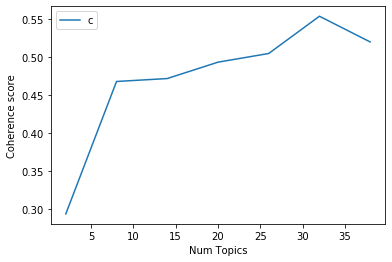

In [81]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [82]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2938
Num Topics = 8  has Coherence Value of 0.4676
Num Topics = 14  has Coherence Value of 0.4715
Num Topics = 20  has Coherence Value of 0.493
Num Topics = 26  has Coherence Value of 0.5044
Num Topics = 32  has Coherence Value of 0.5533
Num Topics = 38  has Coherence Value of 0.5196


In [125]:
#Get the model with the highest coherence scores 
optimal_model = model_list[5]
#what are the words in tops of the optimal model
model_topics = optimal_model.show_topics(formatted=False)
pp.pprint(optimal_model.print_topics(num_words=10))

[(20,
  '0.015*"[\'front\'," + 0.012*"\'anyon\']" + 0.011*"\'expens\']" + '
  '0.010*"\'plu\']" + 0.009*"\'franci\'," + 0.009*"\'tough\'," + '
  '0.008*"\'reciev\'," + 0.008*"[\'close\'," + 0.007*"[\'ask\'," + '
  '0.007*"[\'two\',"'),
 (3,
  '0.012*"\'stain\'," + 0.008*"\'carpet\'," + 0.007*"\'worn\'," + '
  '0.007*"\'bug\'," + 0.006*"\'paint\'," + 0.005*"\'man\'," + '
  '0.005*"\'peel\'," + 0.005*"\'paper\'," + 0.004*"\'clearli\'," + '
  '0.004*"\'gross\',"'),
 (31,
  '0.005*"\'walk\'," + 0.005*"\'locat\'," + 0.004*"\'squar\'," + '
  '0.004*"\'good\'," + 0.004*"\'time\'," + 0.004*"\'hotel\'," + '
  '0.003*"\'great\'," + 0.003*"\'clean\'," + 0.003*"\'park\'," + '
  '0.003*"\'central\',"'),
 (11,
  '0.018*"\'western\'," + 0.016*"\'elsewher\']" + 0.015*"\'dump\'," + '
  '0.014*"[\'check\'," + 0.011*"\'knock\'," + 0.011*"\'bang\'," + '
  '0.010*"\'pipe\'," + 0.010*"\'shame\'," + 0.009*"\'constant\'," + '
  '0.008*"\'rude\',"'),
 (10,
  '0.016*"[\'clean\'," + 0.016*"\'awaken\'," + 0.014*"

In [100]:
# Save optimal model to disk so we don't need to rerun
from gensim.test.utils import datapath
temp_file = datapath("optimized_model")
optimal_model.save(temp_file)

## Visualizing Optimized LDA model 

In [101]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, reviews_corpus, reviews_dict)
vis

//anaconda/envs/bird_view/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.463912  0.098800       1        1  44.961903
9     -0.421537  0.037401       2        1  14.040491
31    -0.389079  0.032573       3        1  13.223031
2     -0.325406 -0.090211       4        1   4.183074
3     -0.350522 -0.001678       5        1   4.108668
1     -0.145405 -0.131151       6        1   1.622918
11    -0.036015 -0.178658       7        1   1.117283
15     0.007784  0.028135       8        1   1.005140
25     0.006709  0.010572       9        1   0.907036
16     0.063890  0.025927      10        1   0.818594
13     0.046692 -0.013922      11        1   0.812675
17     0.063022  0.010241      12        1   0.798923
27     0.061965 -0.003529      13        1   0.781181
28     0.051753  0.007515      14        1   0.752249
23     0.095758  0.010045      15        1   0.715451
30     0.097415  0.013170      16        1   0.668798
26     0.097519  0.016377      17        1   0.665569
7      0.093989  0.013964      18        1   0.644317
6      0.098533  0.013773      19        1   0.635482
21     0.098196  0.009110      20        1   0.633019
20     0.097359  0.013775      21        1   0.622372
10     0.091366  0.015550      22        1   0.615035
14     0.105316  0.010467      23        1   0.589403
19     0.097493  0.010095      24        1   0.588823
0      0.107273  0.008253      25        1   0.579053
29     0.107291  0.004784      26        1   0.578701
24     0.105734  0.005393      27        1   0.575942
4      0.103986  0.005554      28        1   0.569123
5      0.107761  0.005458      29        1   0.562900
22     0.108643  0.006039      30        1   0.561837
8      0.108182  0.004695      31        1   0.533565
12     0.108245  0.001482      32        1   0.527451, topic_info=     Category        Freq           Term       Total  loglift  logprob
1112  Default  179.000000        'rude',  179.000000  30.0000  30.0000
43    Default  259.000000      'carpet',  259.000000  29.0000  29.0000
72    Default  198.000000     'terribl',  198.000000  28.0000  28.0000
500   Default  153.000000       'stain',  153.000000  27.0000  27.0000
3537  Default  102.000000   'uncomfort',  102.000000  26.0000  26.0000
2082  Default  290.000000       'smoke',  290.000000  25.0000  25.0000
6984  Default   77.000000     'disgust',   77.000000  24.0000  24.0000
2793  Default  164.000000     'horribl',  164.000000  23.0000  23.0000
2561  Default   78.000000      'refund',   78.000000  22.0000  22.0000
3645  Default   66.000000       'drain',   66.000000  21.0000  21.0000
1883  Default  127.000000         'bug',  127.000000  20.0000  20.0000
1745  Default  207.000000       'worst',  207.000000  19.0000  19.0000
6830  Default   55.000000      'shabbi',   55.000000  18.0000  18.0000
3506  Default   59.000000        'woke',   59.000000  17.0000  17.0000
7614  Default   59.000000    'cigarett',   59.000000  16.0000  16.0000
4030  Default  116.000000          'aw',  116.000000  15.0000  15.0000
3527  Default   50.000000        'leak',   50.000000  14.0000  14.0000
98    Default  119.000000      'despit',  119.000000  13.0000  13.0000
2386  Default  209.000000        'poor',  209.000000  12.0000  12.0000
8495  Default   48.000000       'badli',   48.000000  11.0000  11.0000
951   Default   51.000000       'trash',   51.000000  10.0000  10.0000
3490  Default   49.000000        'hole',   49.000000   9.0000   9.0000
1608  Default  117.000000       'paper',  117.000000   8.0000   8.0000
3042  Default   47.000000      'poorli',   47.000000   7.0000   7.0000
840   Default   90.000000        'mold',   90.000000   6.0000   6.0000
1812  Default   93.000000        'worn',   93.000000   5.0000   5.0000
17    Default  433.000000       'great',  433.000000   4.0000   4.0000
6520  Default   50.000000       'crack',   50.000000   3.0000   3.0000
5926  Default   55.000000     'western',   55.000000   2.0000 

In [103]:
pyLDAvis.save_html(vis, 'hotel_reviews.html') # save visualizations for data 